In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community


### Lettura dataset e selezione dei soli giocatori in entrata (evitando così doppi trasferimenti e giocatori svincolati)

In [46]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']
dataset

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70000,NL1,2021,w,385,Fortuna Sittard,Netherlands,in,140032,Andreas Samaris,32.0,...,515,Without Club,Without Club,NaN,1500000.0,False,False,False,False,3633188
70001,NL1,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25.0,...,1293,Tromsø IL,Norway,NaN,500000.0,False,True,True,False,3071862
70002,NL1,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22.0,...,37535,Montevideo City Torque,Uruguay,NaN,100000.0,False,True,True,False,3268245
70003,NL1,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22.0,...,1010,Watford FC,England,NaN,1000000.0,False,True,False,False,3619917


In [25]:
print('colonna player_age Nan -> ' , dataset['player_age'].isna().sum())
print('colonna transfer_fee_amnt Nan -> ' , dataset['transfer_fee_amnt'].isna().sum())
print('colonna market_val_amnt Nan -> ' , dataset['market_val_amnt'].isna().sum())
print('colonna team_name Nan -> ' , dataset['team_name'].isna().sum())
print('colonna counter_team_name Nan -> ' , dataset['counter_team_name'].isna().sum())
retired_rows = dataset[(dataset['team_id'] == 'Retired') | (dataset['counter_team_id'] == 'Retired')]
print('colonne team_id o counter_team_id Retired -> ', retired_rows.shape[0])
print('Numero di campioni in cui la colonna is_loan_ended è True ->', (dataset['is_loan_end'] == True).sum())

colonna player_age Nan ->  6
colonna transfer_fee_amnt Nan ->  18669
colonna market_val_amnt Nan ->  7523
colonna team_name Nan ->  0
colonna counter_team_name Nan ->  0
colonne team_id o counter_team_id Retired ->  2
Numero di campioni in cui la colonna is_loan_ended è True -> 8719


### Preprocessing:
##### - Rimuoviamo i 6 trasferimenti il cui player_age è Nan (per eventuali analisi future sull'età)
##### - Sostituiamo i Nan di transfer_fee_amnt con 0 (per eventuali analisi future sui valori di trasferimento)
##### - Sostituiamo i Nan di market_val_amnt con 0 (per eventuali analisi future sui valori di mercato)
##### - Seleziono solo i trasferimenti in cui la colonna 'counter_team_name' è diversa da 'Without Club' in quanto questa indica giocatori svincolati
##### - Seleziono solo i trasferimenti in cui la colonna 'team_name' è diversa da 'Without Club' in quanto questa indica l'ingaggio di giocatori svincolati
#### - Rimuovo le righe in cui è presente in Counter_team_id e counter_team_name la parola Retired (ritirato)

In [47]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1171/3190214965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(subset=['player_age'], inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1171/3190214965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['transfer_fee_amnt'].fillna(0, inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1171/3190214965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

### Inizio costruzione della rete
#### Ogni team deve avere:
##### - un id
##### - un nome
##### - un paese e un codice lega (GB1 ad esempio)
### I team devono essere presi sia da team_name che da counter_team_name
#### Ogni trasferimento deve avere: 
##### - un id di trasferimento (?)
##### - un player id 
##### - un player name
##### - l'età del player
##### - una season
##### - una finestra di mercato (invernale o estiva)
##### - un valore di trasferimento
##### - un bool che indica se è in prestito o a titolo definitivo
##### - il valore di mercato (?)

In [48]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


In [28]:
print('Nodi -> ', G.number_of_nodes())
print('Archi -> ', G.number_of_edges())
print('Density -> ', nx.density(G))

Nodi ->  2193
Archi ->  22696
Density ->  0.00472139288579122


Uno dei problemi che spesso si presenta in questa disciplina è l'esplosione delle reti, che sorge quando la rete cresce rapidamente in dimensioni e complessità a causa dell'aggiunta di nuovi nodi o archi. 
Questo fenomeno può influenzare notevolmente l'accuratezza e la significatività dei risultati ottenuti attraverso l'analisi delle reti.
### Seleziona solo i nodi che hanno almeno 10 archi in totale tra ingresso e uscita



In [61]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno un arco in ingresso e uno in uscita 
selected_teams = [node for node in G.nodes() if out_degree[node] > 0 and in_degree[node] > 0 ] 

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  239  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  3  nodi con tutte le operazioni di mercato a 0
Nodi ->  236
Archi ->  11648
Density ->  0.21002524341868012


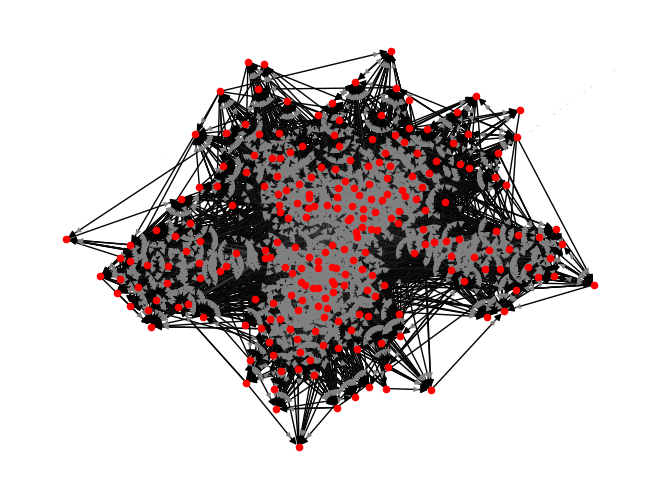

In [17]:
# Disegna il grafo
pos = nx.spring_layout(net)  # Posiziona i nodi in modo che siano ben distribuiti

# Disegna i nodi senza etichette
nx.draw(net, pos, with_labels=False, node_size=20, node_color='red')

# Disegna gli archi
nx.draw_networkx_edges(net, pos, width=0.02, edge_color='gray')

# Mostra il grafico
plt.axis('off')  # Nasconde gli assi
plt.show()

## Misure: grado di centralità 
#### Misura il numero di connessioni in entrata e in uscita da un nodo all'interno della rete. I nodi con un grado di centralità più elevato sono considerati più importanti all'interno della rete poichè hanno più connessioni con altri nodi. Nel nostro caso può essere utilizzata per identificare quelli che sono i club più attivi e influenti nel calciomercato dal 2009 al 2021 così come quelli meno attivi. In particolare vengono identificati:
#### - I nodi più importanti della rete -> maggior numero di connessioni con gli altri nodi. Indicano club più attivi e influenti.
#### - I nodi di confine -> minor numero di connessioni. Indicano i club meno influenti nel calciomercato
#### - Comunità -> la centralità di grado può essere utilizzata per identificare comunità di club. Le comunità sono gruppi di nodi altamente connessi tra loro e con meno connessioni ai nodi esterni al gruppo. Nel nostro caso può aiutare a identificare gruppi di club tra cui sono avvenuti molti trasferimenti nel periodo preso in esame. 

In [54]:
# Cerca i club con il maggior numero di trasferimenti (senza utilizzare la rete)
'''
# Raggruppa i dati per squadra e conta i trasferimenti
team_transfers_count = dataset['team_name'].value_counts()

# Trova le prime 10 squadre con il maggior numero di trasferimenti
top_10_teams = team_transfers_count.head(10)

print("Le prime 10 squadre con il maggior numero di trasferimenti:")
print(top_10_teams)
'''

# Calcola il grado di centralità di tutti i nodi
degree_centrality = nx.degree_centrality(net)

club_presence_count = dict(net.degree())

# Ordina i nodi in base alla centralità di grado in ordine decrescente
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Seleziona i primi 10 club più influenti / attivi
top_10_clubs = sorted_nodes[:10]

# Seleziona gli ultimi 10 club meno influenti / meno attivi
bottom_10_clubs = sorted_nodes[-10:]

# Stampa i risultati
print("I 10 club più influenti:")
for club, centrality in top_10_clubs:
    club_id = club
    club_name = G.nodes[club]['name']
    club_presence = club_presence_count[club_id]
    print("ID del club:", club_id, " - Nome del club: ", club_name, " - Centralità di grado: ", centrality, " - Presenze: ", club_presence)

print("\nI 10 club meno influenti:")
for club, centrality in bottom_10_clubs:
    club_id = club
    club_name = G.nodes[club]['name']
    club_presence = club_presence_count[club_id]
    print("ID del club:", club_id, " - Nome del club: ", club_name, " - Centralità di grado: ", centrality, " - Presenze: ", club_presence)


I 10 club più influenti:
ID del club: 252  - Nome del club:  Genoa CFC  - Centralità di grado:  1.8553191489361702  - Presenze:  436
ID del club: 46  - Nome del club:  FC Internazionale  - Centralità di grado:  1.4936170212765958  - Presenze:  351
ID del club: 506  - Nome del club:  Juventus FC  - Centralità di grado:  1.4170212765957446  - Presenze:  333
ID del club: 12  - Nome del club:  AS Roma  - Centralità di grado:  1.319148936170213  - Presenze:  310
ID del club: 130  - Nome del club:  Parma Calcio 1913  - Centralità di grado:  1.319148936170213  - Presenze:  310
ID del club: 5  - Nome del club:  AC Milan  - Centralità di grado:  1.2425531914893617  - Presenze:  292
ID del club: 410  - Nome del club:  Udinese Calcio  - Centralità di grado:  1.2170212765957447  - Presenze:  286
ID del club: 720  - Nome del club:  FC Porto  - Centralità di grado:  1.2127659574468086  - Presenze:  285
ID del club: 294  - Nome del club:  SL Benfica  - Centralità di grado:  1.1787234042553192  - Pres

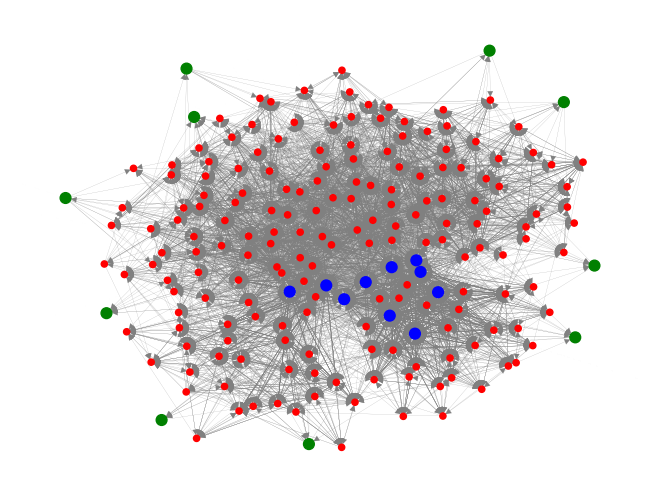

In [63]:
# Nodi più influenti e nodi meno influenti (di confine)

# Seleziona i nodi top 10 e bottom 10 insieme ai loro vicini
selected_nodes = [node for node, _ in top_10_clubs] + [node for node, _ in bottom_10_clubs]
subgraph = net.subgraph(selected_nodes)

# Estrai il sottografo completo che include tutti i nodi collegati ai nodi selezionati
full_subgraph = net.subgraph(list(subgraph.nodes) + [edge[1] for edge in net.edges(subgraph.nodes)])

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in full_subgraph.nodes:
    if node in [club for club, _ in top_10_clubs]:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(60)  # Dimensione più grande per i nodi blu
    elif node in [club for club, _ in bottom_10_clubs]:
        node_colors.append('green')  # Nodi bottom 10
        node_sizes.append(60)  # Dimensione più grande per i nodi verdi
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(20)  # Dimensione più piccola per i nodi rossi

# Disegna il grafo completo
pos = nx.kamada_kawai_layout(full_subgraph)
nx.draw(full_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

# Visualizza il grafo
plt.show()


## Team con più acquisti e cessioni

In [90]:
# Crea una lista di tuple (squadra, trasferimenti_in_uscita) per ogni squadra
outbound_transfers = {}

for team_node in net.nodes():
    team_name = net.nodes[team_node]['name']
    outbound_transfers[team_name] = 0

for team_node in net.nodes():
    out_edges = net.out_edges(team_node, data=True)
    for _, _, edge_attrs in out_edges:
        if edge_attrs['label'] == 'transfer':
            team_name = net.nodes[team_node]['name']
            outbound_transfers[team_name] += 1

# Ordina la lista in base al numero di trasferimenti in uscita in ordine decrescente
sorted_outbound_teams = sorted(outbound_transfers.items(), key=lambda x: x[1], reverse=True)

# Ottieni le prime 10 squadre con il maggior numero di trasferimenti in uscita
top_10_outbound_teams = sorted_outbound_teams[:10]

# Stampa le prime 10 squadre con il maggior numero di trasferimenti in uscita
for team_name, transfers in top_10_outbound_teams:
    print(f"Squadra: {team_name}")
    print(f"Trasferimenti in uscita: {transfers}")
    print()

Squadra: FC Internazionale
Trasferimenti in uscita: 216

Squadra: Chelsea FC
Trasferimenti in uscita: 208

Squadra: Genoa CFC
Trasferimenti in uscita: 207

Squadra: FC Porto
Trasferimenti in uscita: 200

Squadra: SL Benfica
Trasferimenti in uscita: 193

Squadra: Juventus FC
Trasferimenti in uscita: 193

Squadra: AS Roma
Trasferimenti in uscita: 174

Squadra: Udinese Calcio
Trasferimenti in uscita: 167

Squadra: Manchester City
Trasferimenti in uscita: 157

Squadra: Sporting CP
Trasferimenti in uscita: 151



In [91]:
# Crea una lista di tuple (squadra, trasferimenti_in_entrata) per ogni squadra
inbound_transfers = {}

for team_node in net.nodes():
    team_name = net.nodes[team_node]['name']
    inbound_transfers[team_name] = 0

for team_node in net.nodes():
    in_edges = net.in_edges(team_node, data=True)
    for _, _, edge_attrs in in_edges:
        if edge_attrs['label'] == 'transfer':
            team_name = net.nodes[team_node]['name']
            inbound_transfers[team_name] += 1

# Ordina la lista in base al numero di trasferimenti in entrata in ordine decrescente
sorted_inbound_teams = sorted(inbound_transfers.items(), key=lambda x: x[1], reverse=True)

# Ottieni le prime 10 squadre con il maggior numero di trasferimenti in entrata
top_10_inbound_teams = sorted_inbound_teams[:10]

# Stampa le prime 10 squadre con il maggior numero di trasferimenti in entrata
for team_name, transfers in top_10_inbound_teams:
    print(f"Squadra: {team_name}")
    print(f"Trasferimenti in entrata: {transfers}")
    print()

Squadra: Genoa CFC
Trasferimenti in entrata: 229

Squadra: Parma Calcio 1913
Trasferimenti in entrata: 203

Squadra: UC Sampdoria
Trasferimenti in entrata: 145

Squadra: AC Milan
Trasferimenti in entrata: 142

Squadra: Juventus FC
Trasferimenti in entrata: 140

Squadra: AS Roma
Trasferimenti in entrata: 136

Squadra: FC Internazionale
Trasferimenti in entrata: 135

Squadra: ACF Fiorentina
Trasferimenti in entrata: 131

Squadra: Chievo Verona
Trasferimenti in entrata: 125

Squadra: Bologna FC 1909
Trasferimenti in entrata: 123



In [65]:
# Crea un dizionario per tenere traccia del numero di trasferimenti per ogni calciatore
player_movement_count = {}

for (source, target, key) in net.edges(keys=True):
    player_name = net.edges[source, target, key]['player_name']
    
    # Se il calciatore non è presente nel dizionario, inizializza il conteggio a 1
    if player_name not in player_movement_count:
        player_movement_count[player_name] = 1
    else:
        # Altrimenti, incrementa il conteggio di 1
        player_movement_count[player_name] += 1

# Ordina i calciatori in base al numero di trasferimenti in ordine decrescente
sorted_players = sorted(player_movement_count.items(), key=lambda x: x[1], reverse=True)

# Ottieni i primi 5 calciatori più mobili
top_5_mobile_players = sorted_players[:5]

# Stampa i nomi dei calciatori e il numero di trasferimenti per i primi 5 calciatori più mobili
for player_name, movement_count in top_5_mobile_players:
    print(f"Calciatore: {player_name}, Numero di Trasferimenti: {movement_count}")

Calciatore: Mattia Destro, Numero di Trasferimenti: 10
Calciatore: Emiliano Viviano, Numero di Trasferimenti: 10
Calciatore: Kevin-Prince Boateng, Numero di Trasferimenti: 10
Calciatore: Valerio Verre, Numero di Trasferimenti: 10
Calciatore: Roberto, Numero di Trasferimenti: 10


## Community

Community 1: ['Stoke City', 'Reading FC', 'Arsenal FC', 'Queens Park Rangers', 'Manchester City', 'Valencia CF', 'Villarreal CF', 'Everton FC', 'Liverpool FC', 'Sunderland AFC', 'Girona FC', 'Hércules CF', 'Levante UD', 'Wigan Athletic', 'Málaga CF', 'CA Osasuna', 'Birmingham City', 'Deportivo Alavés', 'Cardiff City', 'Sheffield United', 'Norwich City', 'Bolton Wanderers', 'Crystal Palace', 'Burnley FC', 'Athletic Bilbao', 'Real Valladolid CF', 'Rayo Vallecano', 'Sevilla FC', 'Racing Santander', 'West Ham United', 'Brentford FC', 'Getafe CF', 'Cádiz CF', 'Middlesbrough FC', 'FC Barcelona', 'Xerez CD', 'CD Tenerife', 'Real Zaragoza', 'Leeds United', 'Sporting Gijón', 'Tottenham Hotspur', 'Aston Villa', 'Real Betis Balompié', 'Granada CF', 'Blackpool FC', 'Real Madrid', 'Fulham FC', 'Blackburn Rovers', 'Real Sociedad', 'Celta de Vigo', 'Southampton FC', 'Hull City', 'RCD Espanyol Barcelona', 'West Bromwich Albion', 'Manchester United', 'UD Las Palmas', 'CD Leganés', 'AFC Bournemouth', 'C

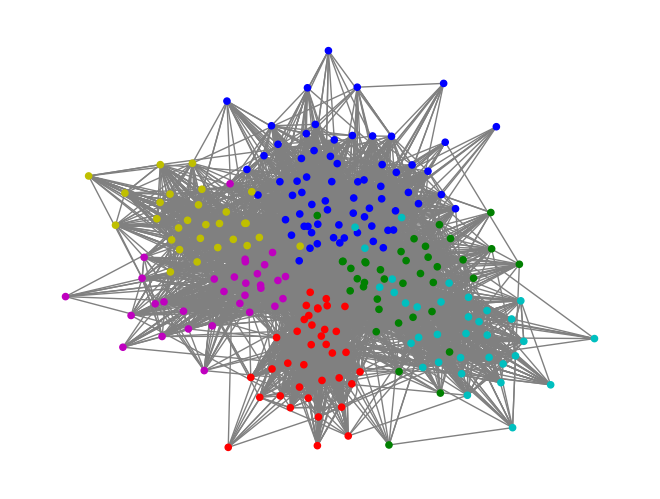

In [82]:
# Converti il grafo in un grafo non direzionato
undirected_net = net.to_undirected()

# Esegui l'algoritmo di rilevamento delle comunità sul grafo non direzionato
communities = list(nx.algorithms.community.greedy_modularity_communities(undirected_net))


# Stampa le comunità identificate con i nomi dei team
for i, community in enumerate(communities):
    team_names = [undirected_net.nodes[node]['name'] for node in community]
    print(f"Community {i + 1}: {team_names}")


# Crea un dizionario che associa i nodi alle comunità
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Crea una lista di colori per le comunità
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Estrai i colori dei nodi in base alle comunità
node_colors = [colors[node_to_community[node] % len(colors)] for node in undirected_net.nodes()]

# Disegna il grafo
pos = nx.spring_layout(undirected_net)  # Puoi scegliere diversi layout a seconda delle preferenze
nx.draw(undirected_net, pos, node_color=node_colors, with_labels=False, node_size=20, edge_color='gray')
plt.show()


In [85]:
# Calcola la betweenness centrality dei nodi nel grafo non direzionato
betweenness_centrality = nx.betweenness_centrality(undirected_net)

# Ordina i nodi per la betweenness centrality in ordine decrescente
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampa i primi 10 nodi con la betweenness centrality maggiore e i loro nomi di team
top_10_nodes = sorted_nodes[:10]
for node, centrality in top_10_nodes:
    team_name = undirected_net.nodes[node]['name']  # Assumi che 'name' sia l'attributo associato ai nodi per il nome del team
    print(f"Node: {node}, Team Name: {team_name}, Betweenness Centrality: {centrality}")


Node: 336, Team Name: Sporting CP, Betweenness Centrality: 0.027763478030427766
Node: 720, Team Name: FC Porto, Betweenness Centrality: 0.021657689075593293
Node: 294, Team Name: SL Benfica, Betweenness Centrality: 0.018079411975427964
Node: 162, Team Name: AS Monaco, Betweenness Centrality: 0.01745369070300057
Node: 410, Team Name: Udinese Calcio, Betweenness Centrality: 0.017204626943278532
Node: 631, Team Name: Chelsea FC, Betweenness Centrality: 0.015832044455017284
Node: 252, Team Name: Genoa CFC, Betweenness Centrality: 0.01495182813632546
Node: 281, Team Name: Manchester City, Betweenness Centrality: 0.014852980361740894
Node: 368, Team Name: Sevilla FC, Betweenness Centrality: 0.013292914950165529
Node: 1075, Team Name: SC Braga, Betweenness Centrality: 0.012899618036455361


## Grado medio ponderato
##### Il grado medio ponderato indica l'importanza media dei team in base al valore finanziario dei trasferimenti di giocatori associati a ciascun team. In altre parole, rappresenta l'importanza media di una squadra nel mercato dei trasferimenti dei giocatori. Quando calcoli il grado medio ponderato, stai considerando il valore totale dei trasferimenti in entrata e in uscita per ciascun team e lo dividi per il numero di tali trasferimenti. Questo valore rappresenta una stima dell'importanza finanziaria media di ciascun team nella rete di trasferimenti dei giocatori. Un grado medio ponderato più alto indica che un team è coinvolto in trasferimenti di giocatori di valore superiore, mentre un grado medio ponderato più basso indica trasferimenti di valore inferiore.
#### Si può usare questa metrica per identificare le squadre che sono economicamente più influenti nella rete dei trasferimenti dei giocatori. Le squadre con un grado medio ponderato più alto sono quelle che sono coinvolte in trasferimenti di giocatori con un valore finanziario complessivamente più alto rispetto alle altre squadre.

In [94]:
# Inizializza un dizionario per memorizzare il grado medio ponderato di ciascun nodo
weighted_degrees = {}

# Calcola il grado medio ponderato per ciascun nodo
for node in net.nodes():
    if net.nodes[node]['label'] == 'team':
        total_in_weight_sum = 0
        total_out_weight_sum = 0
        in_node_count = 0
        out_node_count = 0
        
        for _, _, data in net.in_edges(node, data=True):
            total_in_weight_sum += data['transfer_fee_amnt']
            in_node_count += 1
        
        for _, _, data in net.out_edges(node, data=True):
            total_out_weight_sum += data['transfer_fee_amnt']
            out_node_count += 1

        if in_node_count > 0 and out_node_count > 0:
            average_weighted_degree = (total_in_weight_sum + total_out_weight_sum) / (in_node_count + out_node_count)
            weighted_degrees[node] = average_weighted_degree

# Ordina i nodi in base al grado medio ponderato in ordine decrescente
sorted_weighted_degrees = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)

# Stampa i primi 10 nodi con il grado medio ponderato più alto, includendo il nome del team
for i, (node, weighted_degree) in enumerate(sorted_weighted_degrees[:10]):
    team_name = net.nodes[node]['name']
    print(f"Nodo: {node}, Nome Team: {team_name}, Grado Medio Ponderato: {weighted_degree}")

Nodo: 985, Nome Team: Manchester United, Grado Medio Ponderato: 14410634.328358209
Nodo: 6692, Nome Team: Novara Calcio 1908, Grado Medio Ponderato: 14029729.72972973
Nodo: 131, Nome Team: FC Barcelona, Grado Medio Ponderato: 14005147.928994082
Nodo: 418, Nome Team: Real Madrid, Grado Medio Ponderato: 12934269.662921349
Nodo: 1148, Nome Team: Brentford FC, Grado Medio Ponderato: 11072272.727272727
Nodo: 31, Nome Team: Liverpool FC, Grado Medio Ponderato: 10939880.952380951
Nodo: 281, Nome Team: Manchester City, Grado Medio Ponderato: 10681606.33484163
Nodo: 1003, Nome Team: Leicester City, Grado Medio Ponderato: 10662500.0
Nodo: 16, Nome Team: Borussia Dortmund, Grado Medio Ponderato: 10608458.64661654
Nodo: 583, Nome Team: Paris Saint-Germain, Grado Medio Ponderato: 10442559.523809524
